In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Generate dataframe

In [2]:
inpath = 'data/codedqr-data-3262502.csv'
outpath = None

if (len(sys.argv) == 3):
    inpath = sys.argv[1]
    outpath = sys.argv[2]

print(f'making plots from {inpath}')

# load csv file into a pandas dataframe
df = pd.read_csv(inpath).dropna()

df['total'] = df.iloc[:, 3:].sum(axis=1) - df['recovery']

df = df[['n', 'p', 'f', 'recovery','final solve','post-ortho','cs construct','pbmgs','total']]

# df.to_csv('data/codedqr-data-3249593.csv', index=False)


making plots from data/codedqr-data-3262502.csv


## Total job runtime

In [3]:

seconds = int(df['total'].sum())
mins = seconds // 60
hours = mins // 60
days = hours // 24
seconds %= 60
mins %= 60
hours %= 24

print(f'total execution time: {days}-{hours}:{mins}:{seconds}')


total execution time: 12-6:41:31


## Calculate Proportional Overhead and Sums

In [4]:

# Calculate Tqr for f=0
df['tqr'] = df['pbmgs']

f_zero_dict = df.loc[df['f'] == 0].set_index(['n', 'p'])['tqr'].to_dict()

df.loc[df['f'] != 0, 'tqr'] = df.loc[df['f'] != 0].apply(
    lambda row: f_zero_dict.get((row['n'], row['p']), row['tqr']),
    axis=1
)

# Calculate Tcomp
df['tcomp'] = df['pbmgs'] - df['tqr']

# Take proportions
df['encode'] = df['cs construct'] / df['tqr']
df['post'] = df['post-ortho'] / df['tqr']
df['decode'] = df['recovery'] / df['tqr'] / ( df['p'] + df['f'] )
df['comp'] = df['tcomp'] / df['tqr']

df['overhead'] = df['comp'] + df['encode'] + df['post']

print(df.iloc[:,-5:])

           encode          post        decode      comp      overhead
0    1.476878e-09  2.415391e-07  5.351926e-08  0.000000  2.430159e-07
1    3.563347e-04  5.484704e-04  3.607090e-04  0.273828  2.747331e-01
2    6.199379e-04  3.816257e-04  6.595057e-04  0.551040  5.520414e-01
3    1.019996e-03  3.032268e-04  1.206470e-03  0.817080  8.184033e-01
4    2.289585e-09  3.581759e-07  4.065030e-08  0.000000  3.604655e-07
..            ...           ...           ...       ...           ...
220  1.689779e-04  4.608861e-04  1.872809e-04  0.117080  1.177100e-01
221  3.401973e-04  3.919586e-04  3.654021e-04  0.251498  2.522300e-01
222  4.318944e-04  2.998234e-04  5.166931e-04  0.402093  4.028250e-01
223  1.910105e-10  3.809533e-08  3.600992e-09  0.000000  3.828634e-08
224  1.694746e-04  6.878991e-04  1.975393e-04  0.116481  1.173385e-01

[223 rows x 5 columns]


## Take averages for all iterations

In [5]:
config_cols = ['n', 'f', 'p']

# df_means = df.groupby(config_cols)[df.columns[3:]].median()
# df_std = (df.groupby(config_cols)[df.columns[3:]].quantile(0.75) - df.groupby(config_cols)[df.columns[3:]].quantile(0.25)) / 2

# Sort the rows by total within each group
df_sorted = df.sort_values(['total']).groupby(config_cols)

# Drop the first and last rows from each group
df_means = df_sorted.apply(lambda x: x.iloc[:][df.columns[3:]].mean())
df_std = df_sorted.apply(lambda x: x.iloc[:][df.columns[3:]].std())

print(df_means[:5])


                  recovery  final solve  post-ortho  cs construct       pbmgs  \
n       f   p                                                                   
12000.0 0.0 6.0   0.000112          0.0    0.000113  5.739017e-07  380.239604   
            8.0   0.000095          0.0    0.000101  5.803420e-07  263.849558   
            10.0  0.000104          0.0    0.000110  5.841777e-07  182.191318   
            12.0  0.000110          0.0    0.000114  5.859675e-07  145.854066   
        1.0 6.0   0.952960          0.0    0.345503  1.365330e-01  484.484782   

                       total         tqr       tcomp        encode  \
n       f   p                                                        
12000.0 0.0 6.0   380.239717  380.239604    0.000000  1.509347e-09   
            8.0   263.849659  263.849558    0.000000  2.199608e-09   
            10.0  182.191428  182.191318    0.000000  3.206466e-09   
            12.0  145.854180  145.854066    0.000000  4.018534e-09   
        1.0 

# Absolute time and overhead over $p$

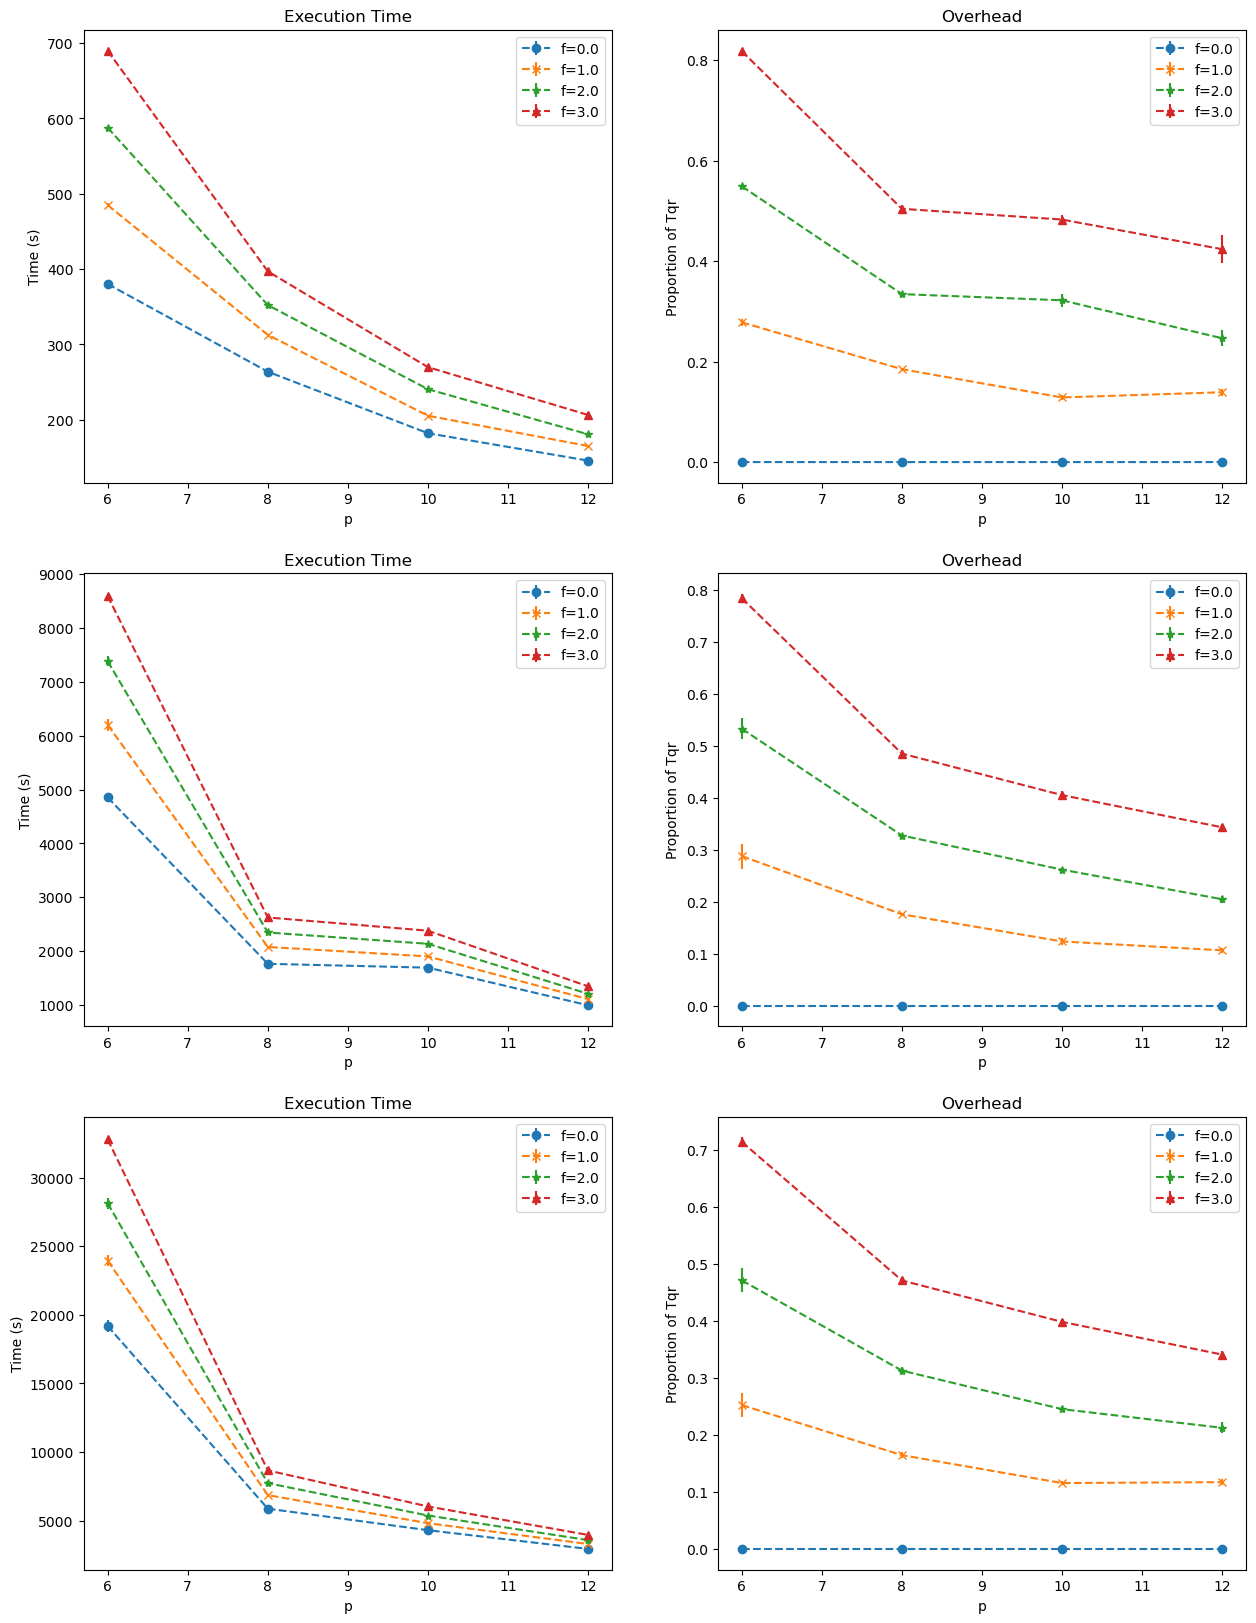

In [6]:

markers = ['o', 'x', '*', '^', 'v', 'p', '>', '<', 'D', 'H']

def inv_exp(x, a, b, c):
    return a * np.exp(-b * x) + c

fig1, plots = plt.subplots(3, 2, figsize=(15, 20))   

for n_val in df['n'].unique():
    
    n_rows = df_means.query(f"n == {n_val}")
    n_std = df_std.query(f"n == {n_val}")
    
     
    time, overhead = plots[int(n_val // 12000 - 1)]
    # fig.text(0.5,0, f'n={n_val}', size=12, ha="center")
    
    for i, f_val in enumerate(df['f'].unique()):
        
        f_rows = n_rows.query(f"f == {f_val}")
        f_std = n_std.query(f"f == {f_val}")
                
        p_vals = f_rows.index.get_level_values('p')
        
        marker = markers[i % len(markers)]
        
        # popt, pcov = curve_fit(inv_exp, p_vals, f_rows['total'])
        # x_fit = np.linspace(min(p_vals), max(p_vals), 1000)
        # y_fit = inv_exp(x_fit, *popt)
        
        time.errorbar(p_vals, f_rows['total'], yerr=f_std['total'], label=f'f={f_val}', linestyle='--', marker=marker)
        overhead.errorbar(p_vals, f_rows['overhead'], yerr=f_std['overhead'], label=f'f={f_val}', linestyle='--', marker=marker)
        # time.plot(x_fit, y_fit, 'r-')
        

    
    time.set_title(f'Execution Time') 
    time.set_xlabel('p')
    time.set_ylabel('Time (s)')
    time.legend()
    
    overhead.set_title(f'Overhead') 
    overhead.set_xlabel('p')
    overhead.set_ylabel('Proportion of Tqr')
    overhead.legend()
    
fig1.show()
       

# Coding Breakdown over $p$

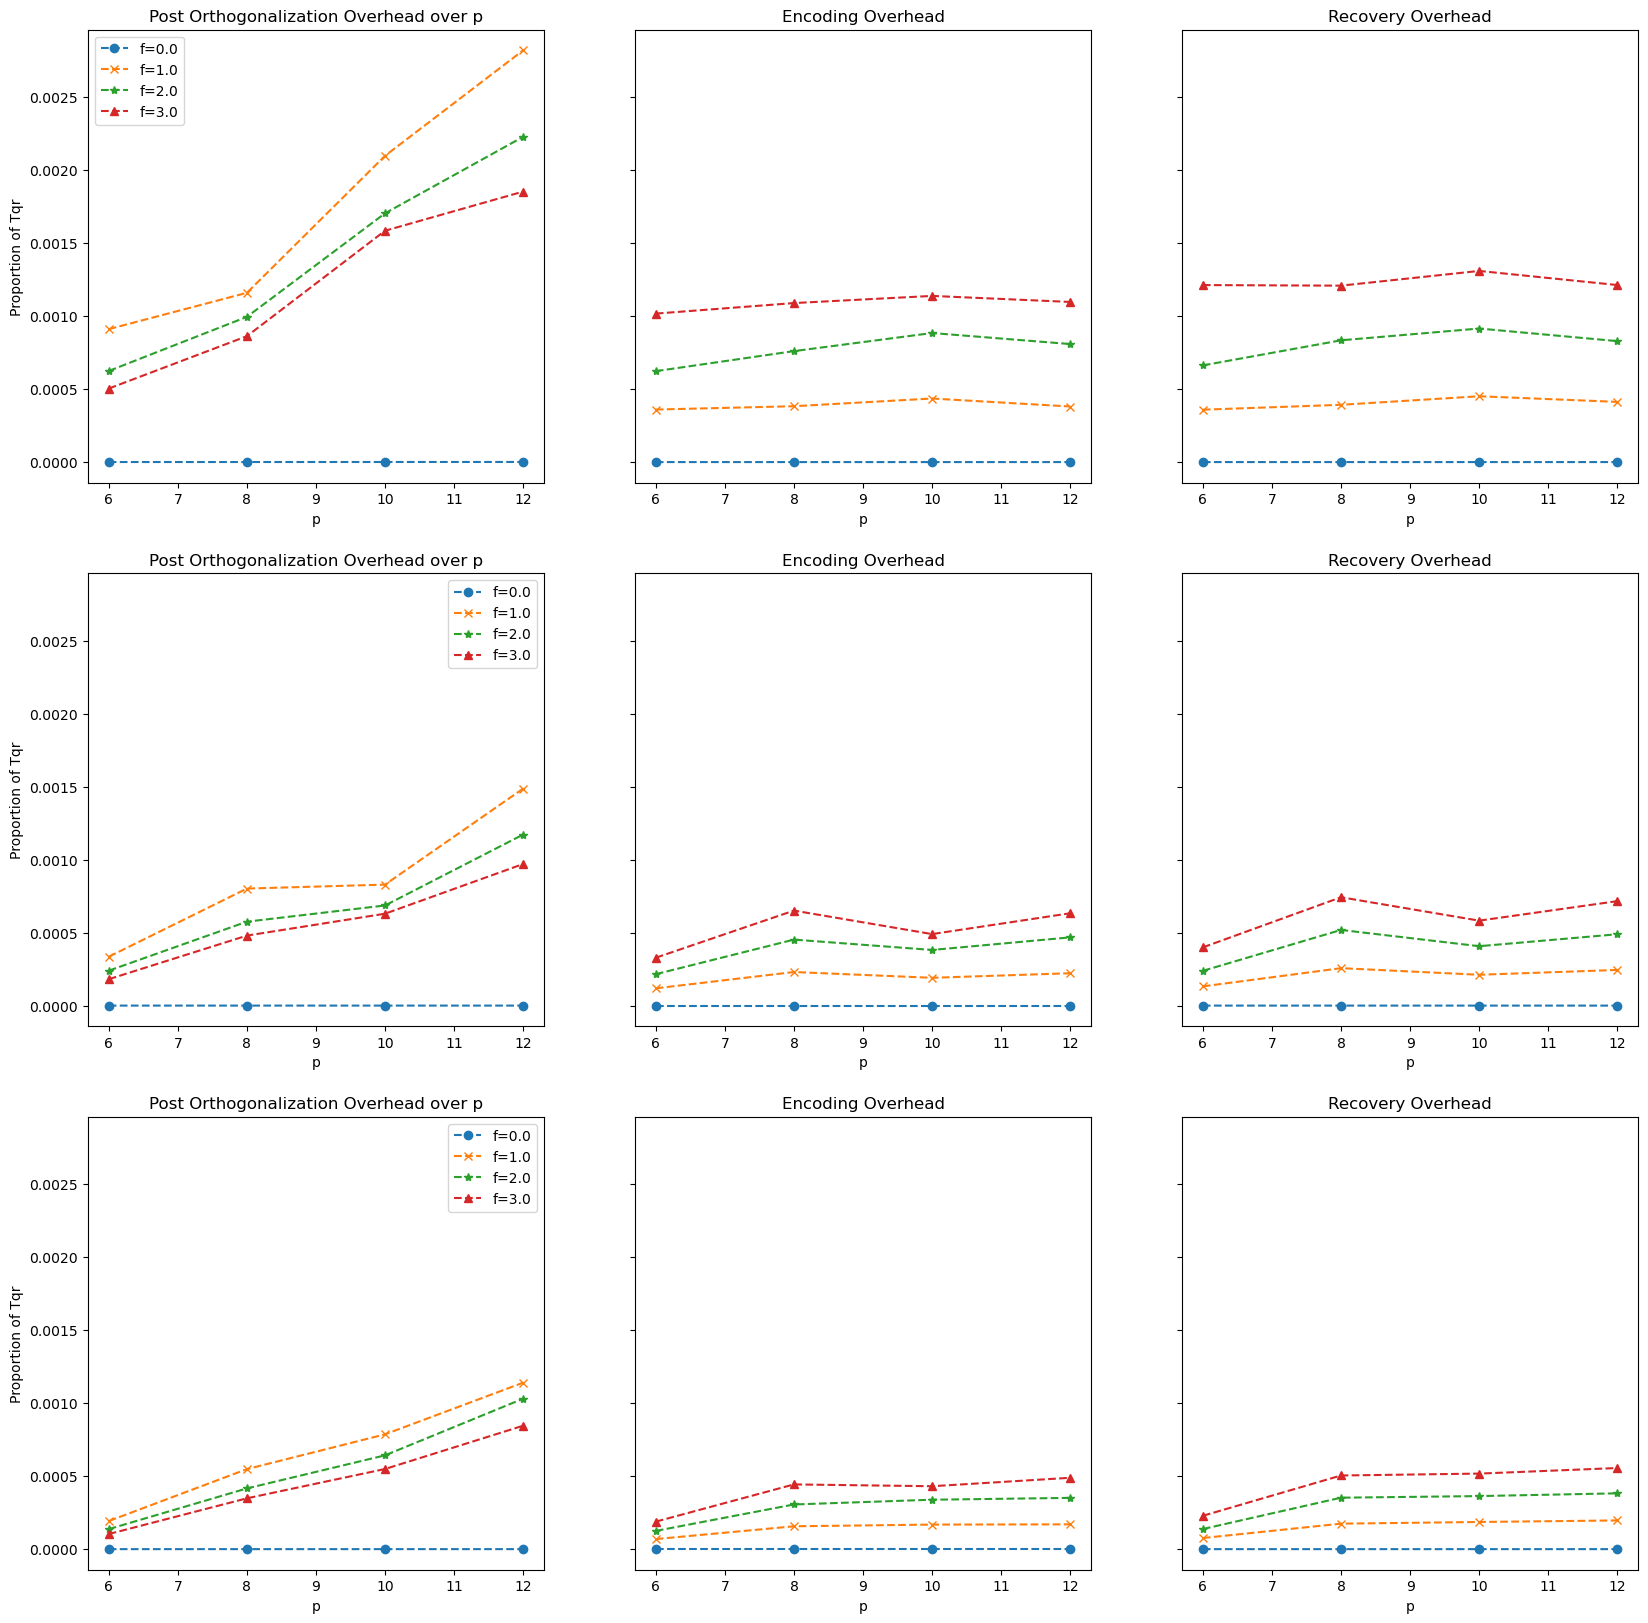

In [7]:
fig2, plots = plt.subplots(3, 3, sharey=True, figsize=(20, 20))
for n_val in df['n'].unique():
    
    n_rows = df_means.query(f"n == {n_val}")
    # n_rows.drop('n', axis=1, inplace=True)
    post, enc, recov = plots[int(n_val // 12000 - 1)]
    # fig.text(0.5,-0.1, f'n={n_val}', size=12, ha="center")  
  
    for i, f_val in enumerate(df['f'].unique()):
        
        f_rows = n_rows.query(f"f == {f_val}")
        # f_rows.drop('f', axis=1, inplace=True)
        
        p_vals = f_rows.index.get_level_values('p')
        
        marker = markers[i % len(markers)]
        
        enc.plot(p_vals, f_rows['encode'], label=f'f={f_val}', linestyle='--', marker=marker)
        recov.plot(p_vals, f_rows['decode'], label=f'f={f_val}', linestyle='--', marker=marker)
        post.plot(p_vals, f_rows['post'], label=f'f={f_val}', linestyle='--', marker=marker)

    
    enc.set_title(f'Encoding Overhead') 
    enc.set_xlabel('p')
    
    
    recov.set_title(f'Recovery Overhead')
    recov.set_xlabel('p')
    
    post.set_title(f'Post Orthogonalization Overhead over p')
    post.set_xlabel('p')
    post.set_ylabel('Proportion of Tqr')
    post.legend()
    
fig2.show()


# Overhead over $f$

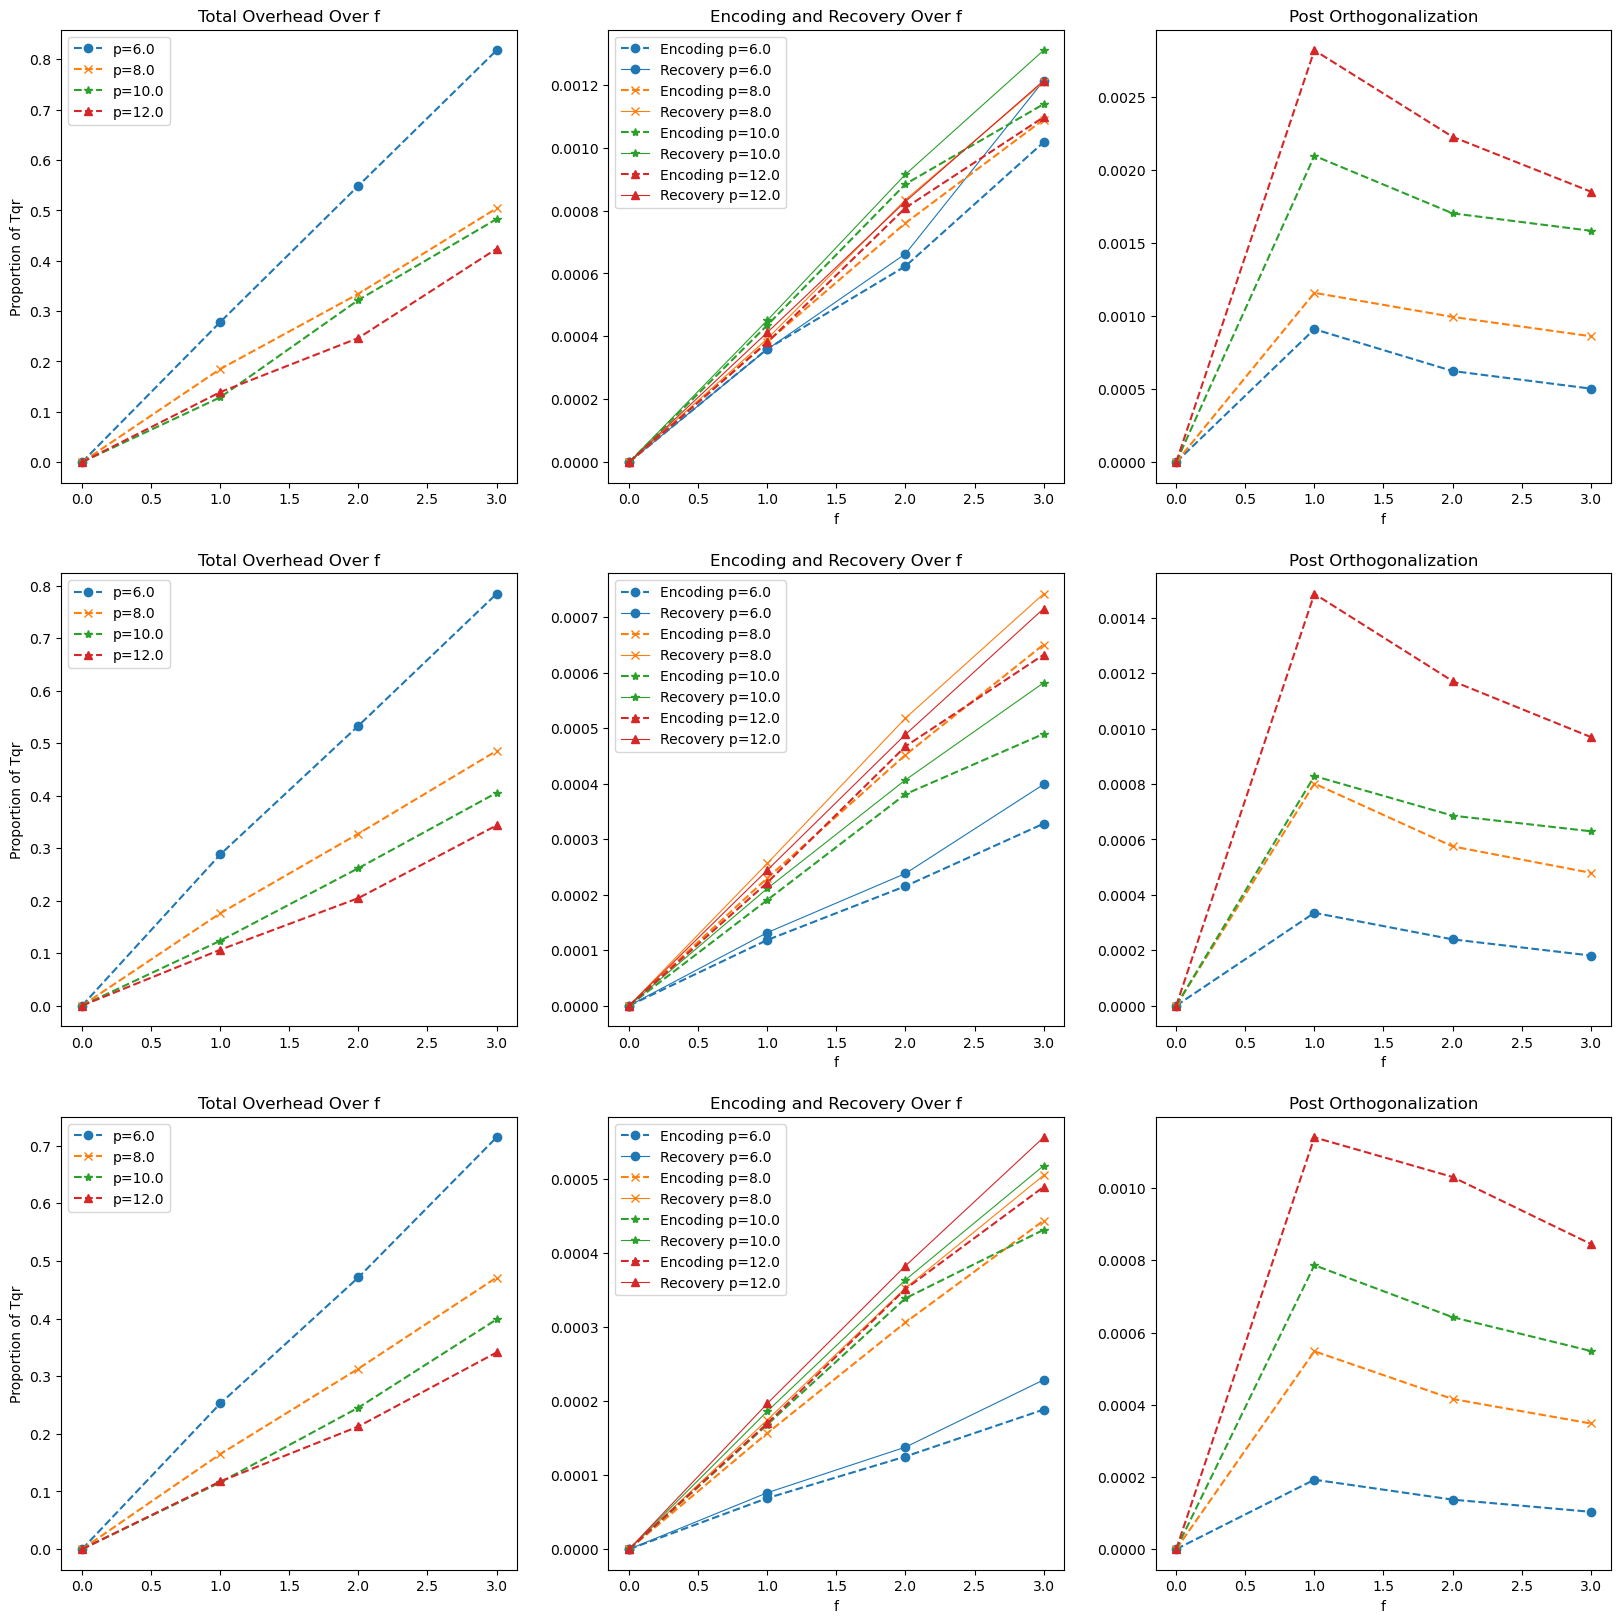

In [8]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

fig3, plots = plt.subplots(3, 3, figsize=(20, 20))

for n_val in df['n'].unique():
    
    n_rows = df_means.query(f"n == {n_val}")
    # n_rows.drop('n', axis=1, inplace=True)

    overhead, enc, post = plots[int(n_val // 12000 - 1)]
    
    # fig.text(0.5,0.05, f'n={n_val}', size=12, ha="center")
    

    for i, p_val in enumerate(df['p'].unique()):
        
        p_rows = n_rows.query(f"p == {p_val}")
        # f_rows.drop('f', axis=1, inplace=True)
        
        f_vals = p_rows.index.get_level_values('f')
        
        marker = markers[i % len(markers)]
        color = colors[i % len(colors)]
        
        overhead.plot(f_vals, p_rows['overhead'], label=f'p={p_val}', linestyle='--', marker=marker, color=color)
        enc.plot(f_vals, p_rows['encode'], label=f'Encoding p={p_val}', linestyle='--', marker=marker, color=color)
        enc.plot(f_vals, p_rows['decode'], label=f'Recovery p={p_val}', linestyle='-', linewidth=0.8, marker=marker, color=color)
        post.plot(f_vals, p_rows['post'], label=f'p={p_val}', linestyle='--', marker=marker, color=color)

    overhead.set_title(f'Total Overhead Over f')
    overhead.set_ylabel('Proportion of Tqr')
    overhead.legend()
    
    enc.set_title(f'Encoding and Recovery Over f') 
    enc.set_xlabel('f')
    enc.legend()

    # recov.set_title(f'Recovery')
    # recov.set_ylabel('Proportion of Tqr')

    post.set_title(f'Post Orthogonalization')
    post.set_xlabel('f')
    
fig3.show()